# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [3]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [5]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-08-17_15-03-19_Australia/0/
Defaulting to output directory name "output" 


In [6]:
from osgeo import gdal

import matplotlib.pyplot as plt

import numpy as np
from numpy import nan
from numpy import isnan

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import pyopencl
import inspect

import time
from datetime import datetime

from tqdm import tqdm

import warnings
warnings.filterwarnings('always')
class Timeseries:
    '''
    
    This is a class that holds a numpy array with time series data, a csv containing dates, and associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path, dates_path):
        
        self.name = time_series_path + "stack.vrt"
        self.dir = time_series_path
        
        self.time_series = gdal.Open(self.name)
        #time_series = self.time_series
        geotransform = self.time_series.GetGeoTransform()
        
        # geo metadata
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]
        self.ncols = self.time_series.RasterXSize
        self.nrows = self.time_series.RasterYSize
        self.projection = self.time_series.GetProjection()
        self.nbands = self.time_series.RasterCount
        
        band = self.time_series.GetRasterBand(1)
        self.block_size = band.GetBlockSize()
        self.time_dict = {}
        
        # self.raster_stack_orig = time_series.ReadAsArray()
        # This takes really long and will likely cause memory issues when running on large countries, so don't use it
        # Use blocks and base block size on what gdal sets or on ram calculation 
        
        # dates file
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))
    def __repr__(self):
            return("Timeseries: {} ".format(self.name))

    def run_bfast(self, block):
        data, dates = crop_data_dates(block, self.dates, self.start_hist, self.end_monitor)

        # only apply on a small subset
        #data = data[:,:80,:80]
        
        # change nans to a number bfastmonitor-GPU can work with
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = -32768

        # fit model
        self.model.fit(data, dates, nan_value = -32768) 
        
        # save breaks and mean magnitudes
        breaks = self.model.breaks # index of date that has a break in dates
        means = self.model.means # magnitudes of breaks
        
        return(breaks,means)
    
    def loop_blocks(self,x_block_size,y_block_size):

        start_time = time.time()
        
        if not x_block_size:
            x_block_size =  self.block_size[0]
        else:
            self.x_block_size = x_block_size
        if not y_block_size:
            y_block_size = self.block_size[1]
        else:
            self.y_block_size = y_block_size
        
        #x_block_size = self.block_size[0]
        #y_block_size = self.block_size[1]
        print("rastersize: ",self.ncols,self.nrows)
        print("The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize: ",self.block_size)
        print("set blocksize explicitly: ",x_block_size,", " ,y_block_size)
        print("bytes required: ", str(8 * self.ncols * self.nrows * self.nbands))
        print("start monitor: ", self.start_monitor)
        print("end monitor: ", self.end_monitor)
        print("start history: ", self.start_hist)
        
        
        first_verstack=True

        # loop over yblocks
        with tqdm(total=(self.ncols/x_block_size)*(self.nrows/y_block_size)) as pbar2:
            pbar2.set_description("Processing blocks of tile:")
                    
                
            for i in range(0, self.nrows, y_block_size):
                
                
                first_horstack = True
                if i + y_block_size < self.nrows:
                    rows = y_block_size
                else:
                    rows = self.nrows - i

                # Loop over xblocks
                for j in range(0, self.ncols, x_block_size):
                    
                    
                    if j + x_block_size < self.ncols:
                        cols = x_block_size
                    else:
                        cols = self.ncols - j

                    print(j,i,cols,rows)

                    # first step creates the array
                    pbar2.update(1)
                    
                    if first_horstack==True:
                        data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                        breaks,means = self.run_bfast(data)
                        breaks_array = breaks
                        means_array = means
                        first_horstack=False

                    # after that add to array
                    else:                    
                        data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                        breaks,means = self.run_bfast(data)
                        breaks_array = np.concatenate((breaks_array,breaks),axis = 1)
                        means_array = np.concatenate((means_array,means),axis = 1)
                
                
                # first step create new variable verstack for the data

                if first_verstack == True:
                    stack_breaks_array = breaks_array
                    stack_means_array = means_array
                    first_verstack = False
                
                # after that add data to array
                else:
                    stack_breaks_array = np.concatenate((stack_breaks_array,breaks_array),axis=0)
                    stack_means_array = np.concatenate((stack_means_array,means_array),axis=0)

            self.breaks_array = stack_breaks_array
            self.means_array = stack_means_array
            
            pbar2.close()
            end_time = time.time()
            print("Fitting model over all blocks took {} seconds.".format(end_time - start_time))
            self.time_dict[self.name] = str(end_time - start_time) + " seconds"

    def set_bfast_parameters(self, start_monitor, end_monitor, start_hist,freq,k,hfrac,trend,level,backend='opencl',verbose=1,device_id=0):
        self.start_monitor = start_monitor
        self.end_monitor = end_monitor
        self.start_hist = start_hist
        self.freq = freq
        self.k = k
        self.hfrac = hfrac
        self.trend = trend
        self.level = level
        self.backend = backend
        self.verbose = verbose
        
        self.model = BFASTMonitor(
                    self.start_monitor,
                    freq=freq, # add these
                    k=k,
                    hfrac=hfrac,
                    trend=trend,
                    level=level,
                    backend=backend,
                    verbose=verbose,
                    device_id=device_id,
                    )
        
        try:
            print(pyopencl.get_platforms()[0].get_devices())
        except:
            print("You selected  openCL, but no device was found, are you sure you set up a gpu session?")

    
    def get_bfast_parameters(self):
        print("Monitoring starts at: ", self.start_monitor)
        print("Monitoring ends at: ", self.end_monitor)
        print("Dataset history starts at: ", self.start_hist)
        print("frequency: ", self.freq)
        print("harmonic term: ", self.k)
        print("Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.: ", self.hfrac)
        print("Trend: Whether a tend offset term shall be used or not: ", self.trend)
        print("Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error: ", self.level)
        print("backend: GPU opencl or CPU python: ", self.backend)
        print("verbose: The verbosity level (0=no output, 1=output): ", self.verbose)
        
    
    def check_arrays(self, min_perc_lacking_data = 20):
        
        minus1count = np.count_nonzero(self.breaks_array == -1) # no break found
        minus2count = np.count_nonzero(self.breaks_array == -2) # not enough data for output
        total_count = self.nrows*self.ncols
        
        print("minus2s: ", minus2count)
        print("minus1s: ", minus1count)
        print("total", total_count)
        
        perc_lacking_data = minus2count/total_count*100
        perc_breaks = (total_count - (minus1count + minus2count))/total_count * 100
        
        print("percentage cells that lacked enough data for finding means or breaks: " + str(perc_lacking_data))
        print("percentage cells where breaks were found: " + str(perc_breaks))
        

        if perc_lacking_data > min_perc_lacking_data:
            return(warnings.warn("Warning: More than {} percent of the pixels in this tile lack sufficient data, resulting in NaNs. Consider selecting a longer monitoring period or a larger area.".format(min_perc_lacking_data)))
    
    def log_output_to_txt(self):

        self.date = str(datetime.now())
        self.device = pyopencl.get_platforms()[0].get_devices()
        
        attributes = inspect.getmembers(self, lambda a:not(inspect.isroutine(a)))
        
        logs_directory = "logs"
        if not os.path.exists("logs"):
            os.makedirs(logs_directory)
        
        save_dir = self.dir
        try:
            start_index = save_dir.find("Time_series")
        except:
            start_index = 1
        save_dir = self.dir.replace("/","-")[start_index:] + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".txt"
        
        
        with open(str(logs_directory + "/" + save_dir), "w") as f:
            for a in attributes:
                if not(a[0].startswith('__') and a[0].endswith('__')):
                    f.write(str(a))
                    f.write("\n")
    
    def log_breaks_means_arrays(self):
        
        arrays_directory = "output_arrays"
        if not os.path.exists("output_arrays"):
            os.makedirs(arrays_directory)
        
        save_dir = self.dir
        try:
            start_index = save_dir.find("Time_series")
        except:
            start_index = 1
        
        save_means_dir = arrays_directory + '/' + self.dir.replace("/","-")[start_index:-1] + "_means.npy"
        save_breaks_dir = arrays_directory + '/' +self.dir.replace("/","-")[start_index:-1] + "_breaks.npy"
        print(save_means_dir)
        print(save_breaks_dir)
        try:
            np.save(save_means_dir, self.means_array)
            np.save(save_breaks_dir,self.breaks_array)
        except:
            print("No arrays are currently loaded")
    
    def load_breaks_means_arrays_from_file(self):
        
        
        arrays_directory = "output_arrays"
        load_dir = self.dir
        try:
            start_index = load_dir.find("Time_series")
        except:
            start_index = 1
        
        load_means_dir = arrays_directory + '/' + self.dir.replace("/","-")[start_index:-1] + "_means.npy"
        load_breaks_dir = arrays_directory + '/' +self.dir.replace("/","-")[start_index:-1] + "_breaks.npy"
        
        self.means_array = np.load(load_means_dir)
        self.breaks_array = np.load(load_breaks_dir)
        
    # Don't work anymore, fix later
    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
        
    def get_size(self):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(self.dir):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                # skip if it is symbolic link
                if not os.path.islink(fp):
                    total_size += os.path.getsize(fp)
        print(self.dir + "   holds  " + str(total_size) + " bytes")

      

# Load in data: if there are tiles in the directory, create a list and load per tile

In [7]:
# set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# check for tiles
file_list = os.listdir(timeseries_directory)
file_list.sort()
for file in file_list:
    if file.startswith('tile'):
        print(file)
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


tile-0000000000-0000000000


In [8]:
# # Set up list of time series tiles and their metadata
if not tile_paths:
    print("No tiles, setting up data as one tile")
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, setting up tiles in 'data_list' ")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)

Data consists of tiles, setting up tiles in 'data_list' 


### Check some metadata of the created Timeseries class

In [9]:
# data_list = data_list[0:2]
#ts_data = data_list[0]
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
#ts_data.log_output_to_txt()

data_list = data_list[0:6]
data_list

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.00026949458523585994


[Timeseries: /home/dven/downloads/Time_series_2020-08-17_15-03-19_Australia/0/tile-0000000000-0000000000/stack.vrt ]

# Set parameters

In [21]:
# parameters
k = 3
freq = 365
trend = True
hfrac = 0.25
level = 0.05
position = (100,100)

backend = 'opencl'
verbose = 1
device_id = 0


# start_hist = datetime(2018, 1, 1)
# start_monitor = datetime(2019, 1, 1)
# end_monitor = datetime(2020, 1, 1)


# Select monitoring period

In [22]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

start monitoring period 2010-03-17 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 3791), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2010-03-17', Timestamp('…

In [23]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

#start_monitor = datetime(2013, 10, 30)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

start monitor:  2015-10-07 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2010-03-17 00:00:00


### Loop over tiles, (or single tile), in data_list

In [24]:
from tqdm import tqdm

# if you get a memory error, set this lower: 256, 128, 512
x_block = y_block = 256


with tqdm(total=len(data_list)) as pbar1:
        
    for counter, ts_data in enumerate(data_list):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )
        ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend=backend,verbose=verbose,device_id=device_id)
        ts_data.loop_blocks(x_block_size = x_block,y_block_size=y_block)
        ts_data.get_bfast_parameters()
        ts_data.log_output_to_txt()
        ts_data.log_breaks_means_arrays()
        pbar1.update(counter)
pbar1.close()

# add warning for large block size, gets stuck? or so?

Processing tile 1 out of 1:   0%|          | 0/1 [00:00<?, ?it/s]
  0%|          | 0/3.234100341796875 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/3.234100341796875 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x3501f30>]
rastersize:  450 471
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
bytes required:  1215745200
start monitor:  2015-10-07 00:00:00
end monitor:  2020-08-02 00:00:00
start history:  2010-03-17 00:00:00
0 0 256 256



Processing blocks of tile::  62%|██████▏   | 2/3.234100341796875 [00:04<00:02,  2.03s/it]

--- runtime for data initialization:		0.002142190933227539
--- runtime for data transfer (host->device):	0.01965808868408203
--- runtime for data preprocessing:		0.005482912063598633
--- runtime for kernel execution:		0.03636431694030762
--- runtime for data transfer (device->host):	0.007969379425048828
256 0 194 256



Processing blocks of tile::  93%|█████████▎| 3/3.234100341796875 [00:07<00:00,  2.53s/it]

--- runtime for data initialization:		0.0021076202392578125
--- runtime for data transfer (host->device):	0.015018701553344727
--- runtime for data preprocessing:		0.003538370132446289
--- runtime for kernel execution:		0.027830839157104492
--- runtime for data transfer (device->host):	0.005880832672119141
0 256 256 215



Processing blocks of tile:: : 4it [00:11,  2.88s/it]                                     

--- runtime for data initialization:		0.002109050750732422
--- runtime for data transfer (host->device):	0.016658544540405273
--- runtime for data preprocessing:		0.0037682056427001953
--- runtime for kernel execution:		0.030621051788330078
--- runtime for data transfer (device->host):	0.006699562072753906
256 256 194 215


Processing blocks of tile:: : 4it [00:14,  3.72s/it]

--- runtime for data initialization:		0.0021147727966308594
--- runtime for data transfer (host->device):	0.012725591659545898
--- runtime for data preprocessing:		0.003233671188354492
--- runtime for kernel execution:		0.023480892181396484
--- runtime for data transfer (device->host):	0.0050792694091796875
Fitting model over all blocks took 14.888345718383789 seconds.
Monitoring starts at:  2015-10-07 00:00:00
Monitoring ends at:  2020-08-02 00:00:00
Dataset history starts at:  2010-03-17 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  True
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-17_15-03-19_Au


Processing tile 1 out of 1:   0%|          | 0/1 [00:15<?, ?it/s]


### Check tiles for output quality

/home/dven/downloads/Time_series_2020-08-17_15-03-19_Australia/0/tile-0000000000-0000000000/
breaks datatype:  int32
means datatype:  int32


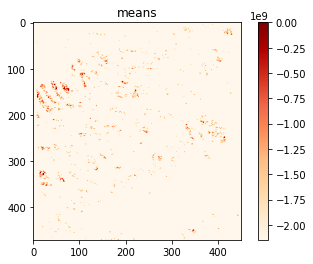

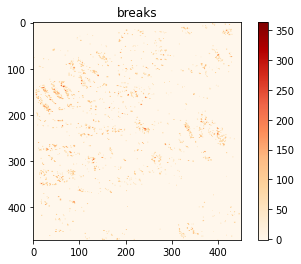

minus2s:  0
minus1s:  208738
total 211950
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 1.515451757489974
mean counts
[[-2147483648      209577]
 [       -488           1]
 [       -400           2]
 [       -396           1]
 [       -394           1]
 [       -389           1]
 [       -366           1]
 [       -359           8]
 [       -354           1]
 [       -336          30]
 [       -331           1]
 [       -325         222]
 [       -320           2]
 [       -319          40]
 [       -315           1]
 [       -314           2]
 [       -310          36]
 [       -303           1]
 [       -288           2]
 [       -285           1]
 [       -284           1]
 [       -281           1]
 [       -280           4]
 [       -277           1]
 [       -274           1]
 [       -273           1]
 [       -251          12]
 [       -244           7]
 [       -240          32]
 [       -235           2]
 [

In [30]:
for tile in data_list:
    print(tile.dir)
    
    # if you want to load in previously saved tiles
    #tile.load_breaks_means_arrays_from_file()
    
    # do some plots
    breaks = ts_data.breaks_array
    means = ts_data.means_array.astype("int32")
    
    print("breaks datatype: ",breaks.dtype)
    print("means datatype: ", means.dtype)
    im = plt.imshow(means, cmap=plt.cm.OrRd)
    plt.colorbar(im);
    plt.title('means')
    plt.show()
    
    im = plt.imshow(breaks, cmap=plt.cm.OrRd)
    plt.colorbar(im);
    plt.title('breaks')
    plt.show()
    
    tile.check_arrays(min_perc_lacking_data = 50)
    
    unique, counts = np.unique(means, return_counts=True)
    
    print("mean counts")
    print(np.asarray((unique, counts)).T[0:300])
    


In [ ]:
# # So this is for merging tiles back together, it seems to work... but need to know for sure.. 
# # since it does not work in one direction, this one should be correct?

# # Make a function to do this




# if len(data_list) > 1:
    
#     x_locs = []
#     y_locs = []
#     for tile in data_list:
#         loc_index = tile.dir.find("tile-")
#         tile_loc = tile.dir[loc_index+5:-1].split("-")
#         print(tile_loc)
#         if tile_loc[0] not in x_locs:
#             x_locs.append(tile_loc[0])
#         if tile_loc[1] not in y_locs:
#             y_locs.append(tile_loc[1])

#     firstx=True
#     for tile in data_list:
#         for x in x_locs:
#             firsty = True

#             for y in y_locs:
#                 if firsty == True:
#                     means_array = tile.means_array
#                     small_means_array = tile.means_array[]
#                     breaks_array = tile.breaks_array
#                     firsty = False
#                 else:
#                     means_array = np.concatenate((means_array, tile.means_array), axis = 1)
#                     breaks_array = np.concatenate((breaks_array, tile.breaks_array), axis = 1)

#         if firstx==True:
#             big_means_array = means_array
#             big_breaks_array = breaks_array     
#             firstx=False
#         else:
#             big_means_array = np.concatenate((big_means_array, means_array),axis = 0)
#             big_breaks_array = np.concatenate((big_breaks_array, breaks_array),axis = 0)


#     # work on new names, and output bit tile stuff so we only have to do it once
    
#     arrays_directory = "output_arrays"
#     if not os.path.exists("output_arrays"):
#         os.makedirs(arrays_directory)

#     try:
#         start_index = save_dir.find("Time_series")
#     except:
#         start_index = 1
    
#     save_dir = timeseries_directory.replace("/","-")[start_index:]
    
    
#     save_means_dir = arrays_directory + "/" + save_dir + "_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_all_means.npy"
#     save_breaks_dir = arrays_directory + "/" + save_dir + "_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_all_breaks.npy"
#     print(save_means_dir)
#     print(save_breaks_dir)
#     np.save(save_means_dir, big_means_array)
#     np.save(save_breaks_dir, big_breaks_array)

    



# # for tile in data_list:
# #     # regex for the word tile:
# #     # then call the numbers col and row
# #     # then first loop over cols, then over rows
# #     print(tile.dir)
# #     namelist.append(tile.dir)
# # tile0_0.
# #print(namelist.sort())

## Run bfastmonitor() The loop_blocks code runs over smaller blocks, that may be set based on ram space or user itself..?


# Select negative magnitudes

In [ ]:
if len(data_list)>1:
    means = big_means_array
    breaks = big_breaks_array
else:
    breaks = ts_data.breaks_array
    means = ts_data.means_array

plt.imshow(means)
plt.show()
plt.imshow(breaks)
plt.show()


In [ ]:
means = data_list[-1].means_array
breaks = data_list[-1].breaks_array

In [ ]:
# import seaborn as sns

# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

# print("magnitude change heatmap")
# sns.heatmap(orig_means,  linewidths=1)


In [ ]:
dates_monitor = []
dates = ts_data.dates
# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [ ]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 

    breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    

# Plot output

In [ ]:
bins = len(idx_starts)
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()



print(bounds)

In [ ]:
print(bounds)

In [ ]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [ ]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

In [ ]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [ ]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

In [ ]:
print(ts_data.latitude)
print(ts_data.longitude)

In [ ]:
# this is probs still wrong

from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + (rows*xpixelsize), longitude + (cols*xpixelsize)]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m